# HOTVis: Implementation

## To Do
- Algo mit Graphen aus Paper testen
- Metriken implementieren

## Imports

In [1]:
import torch
import torch_geometric
import pathpyG as pp
import csv

## Übergabeparameter

In [13]:

# nur hier zum testen
tedges = [('a', 'b', 1),('a', 'b', 2), ('b', 'a', 3), ('b', 'c', 3), ('d', 'c', 4), ('a', 'b', 4), ('c', 'b', 4),
              ('c', 'd', 5), ('b', 'a', 5), ('c', 'b', 6), ('e', 'f', 1), ('f', 'e', 1), ('e', 'f', 2), ('f', 'e', 2), 
              ('e', 'f', 3), ('f', 'e', 3), ('e', 'f', 4), ('f', 'e', 4)]

# mandatory
#graph = pp.TemporalGraph.from_edge_list(tedges)

graph = pp.io.read_csv_temporal_graph('temporal_clusters_real_kregular.tedges', is_undirected = True, timestamp_format='%S')
# read colors
colors = {}
with open('colors.csv', mode="r") as file:
    reader = csv.reader(file)
    next(reader)  # Überspringt die Kopfzeile
    for row in reader:
        number, color = row
        colors[number] = color
style = {}
style['node_color'] = colors
style['node_size'] = 10
style['edge_size'] = 0.1
style['edge_color'] = 'gray'


K = 2
N = 10000
delta = 1
alpha = [0.5, 0.5, 0.5]

# optional
force = 1
positions = torch.rand((graph.N, 2))
# nur hier zum testen
initial_positions = positions
seed = 0

## Initialisierung

In [14]:

A = torch.zeros((graph.N, graph.N))
# the initial "temperature"  is about .1 of domain area (=1x1)
# this is the largest step allowed in the dynamics.
t = 0.1  #max(max(positions.T[0]) - min(positions.T[0]), max(positions.T[1]) - min(positions.T[1])) * 0.1
# simple cooling scheme.
# linearly step down by dt on each iteration so last iteration is size dt.
dt = t / float(N + 1)

## Erste Schleife

Vektorisierung:

Wir benötigen folgende Informationen: Für die Kante $((v_0, ..., v_{k-1}), (v_1,...,v_k))$ eines Higher Order Graphen müssen wir für unseren Algorithmus die Knoten $v_0$ und $v_k$ herausfinden. Bis auf die Benennung der Knoten gibt es keine Datenstruktur wie z.B. eine Adjazenzmatrix in dem Higher Order Graphen, die diese Information direkt oder indirekt beinhaltet. Dadurch müssen wir die Bennenung jeder einzelnen Kante angucken und somit über alle einzelnen Kanten iterieren .

In [15]:
style = {}
style['node_color'] = colors

mo_model = pp.MultiOrderModel.from_temporal_graph(graph, delta=delta, max_order=K)

100%|██████████| 20000/20000 [06:37<00:00, 50.35it/s] 


In [16]:
# iterate over higher orders
for i in range(K):
    ho_graph = mo_model.layers[i+1]
    # iterate over edges of higher order graph
    for edge in ho_graph.edges:
        # for edge ((v_0, ..., v_{k-1}), (v_1,...,v_k)) get nodes v_0 and v_k
        # for i == 0, edge has form (v_0, v_1)
        if(i == 0):
            node_start = edge[0]
            node_end = edge[1]
        # for i > 0, edge has form ((v_0, ..., v_{i-1}), (v_1,...,v_i))
        else:
            node_start = edge[0][0]
            node_end = edge[1][-1]

        # get indices of the nodes
        index_node_start = graph.mapping.to_idx(node_start)
        index_node_end = graph.mapping.to_idx(node_end)

         # TEST
        if(index_node_start==1 and index_node_end==1):
            test = 1

        # add to A
        A[index_node_start, index_node_end] += alpha[i] * ho_graph['edge_weight', edge[0], edge[1]]
    
#print(A)
A_first_loop = A

### Alternative 1. Schleife

In [17]:
# reinitialise
A = torch.zeros((graph.N, graph.N))
#mo_model = pp.MultiOrderModel.from_temporal_graph(graph, delta=delta, max_order=K)

# iterate over higher orders
for i in range(K):
    # get higher order graph
    ho_graph = mo_model.layers[i+1]

    # for edge ((v_0, ..., v_{k-1}), (v_1,...,v_k)) get nodes v_0 and v_k
    nodes_start = ho_graph.data.node_sequence[:,0][ho_graph.data.edge_index[0]]
    nodes_end = ho_graph.data.node_sequence[:,-1][ho_graph.data.edge_index[1]]
    # stack tensors for later use
    indices = torch.stack((nodes_start, nodes_end), dim=0)
    # get edge weights
    edge_weights = ho_graph['edge_weight']
    # remove duplicates while summing their weights up
    indices, edge_weights = torch_geometric.utils.coalesce(indices, edge_weights)
    
    # add weights to A
    A[indices[0], indices[1]] += alpha[i] * edge_weights

A_second_loop = A

Test if the two ways of determining A deliver the same result

In [18]:
print(torch.equal(A_second_loop, A_first_loop))

True


## Zweite Schleife

In [19]:
# names of variables here vs in paper
    # displacement = theta
    # length = |theta|
    # delta = delta
    # distance = |delta|
    # force = k

# every nodes "movement" or displacement gets describet by an tuple (x, y) 
displacement = torch.zeros((graph.N, 2))
for iteration in range(N):
    # reset displacement
    displacement *= 0
    # loop over rows/nodes
    for i in range(A.shape[0]):
        # difference between this row's node position and all others
        delta = positions - positions[i]
        # distance between the nodes
        distance = torch.sqrt((delta**2).sum(dim=1))
        # enforce minimum distance of 0.01
        distance = torch.where(distance < 0.01, 0.01, distance)
        # calculate displacement of node i
        displacement[i] += (delta/distance.view(-1,1) * (A[i] * distance**2 / force -  force**2 / distance).view(-1,1)).sum(dim=0)
    # get length of displacement
    length = torch.sqrt((displacement**2).sum(dim=1))
    # enforce minimum length of 0.01
    length = torch.where(length < 0.01, 0.1, length)
    # add temperature
    length_with_temp = torch.clamp(length, max=t)
    # update positions
    positions += displacement / length.view(-1,1) * length_with_temp.view(-1,1)
    # cool temperature
    t -= dt

positions_first_loop = positions

###  Alternative 2. Schleife

In [20]:
# only now for testing: reinitialize
positions = initial_positions
t=0.1

delta = torch.zeros((positions.shape[0], positions.shape[0], positions.shape[1]))
# the inscrutable (but fast) version
for iteration in pp.tqdm(range(N)):
    # matrix of difference between points
    delta = positions[torch.newaxis, :, :] - positions[:, torch.newaxis, :]#tauschen?
    # distance between points
    distance = torch.linalg.norm(delta, dim=-1)
    # enforce minimum distance of 0.01
    torch.clip(distance, 0.01, None, out=distance)
    # calculate displacement of all nodes
    displacement = torch.einsum('ijk,ij->ik',
                            delta,
                            ( A * distance / force - force**2 / distance**2))
    # calculate length of displacements
    length = torch.linalg.norm(displacement, dim=-1)
    # enforce minimum length of 0.01
    length = torch.where(length < 0.01, 0.1, length)
    # add temperature
    length_with_temp = torch.clamp(length, max=t)
    # calculate the change of the postionions
    delta_positions = torch.einsum('ij,i->ij', displacement, length_with_temp / length)
    # update positions
    positions += delta_positions
    # cool temperature
    t -= dt
   
positions_second_loop = positions

100%|██████████| 10000/10000 [00:48<00:00, 206.06it/s]




## Berechnung der Verschiebung aller Knoten

Die Verschiebung (`displacement`) wird mithilfe eines Einsum-Produkts berechnet:

```python
displacement = torch.einsum('ijk,ij->ik', delta, 
                            (A * distance / force - force**2 / distance**2))
```

### Definition von (`delta`)

`delta` ist definiert als eine 3D-Matrix der Form:

`delta` = 
\begin{bmatrix}
  \begin{bmatrix}
    \text{pos}[1] - \text{pos}[1] \\
    \text{pos}[2] - \text{pos}[1] \\
    \text{pos}[3] - \text{pos}[1] \\
    \vdots \\
    \text{pos}[n] - \text{pos}[1] \\
  \end{bmatrix}
  & 
  \begin{bmatrix}
    \text{pos}[1] - \text{pos}[2] \\
    \text{pos}[2] - \text{pos}[2] \\
    \text{pos}[3] - \text{pos}[2] \\
    \vdots \\
    \text{pos}[n] - \text{pos}[2] \\
  \end{bmatrix}
  &
  \cdots
  &
  \begin{bmatrix}
    \text{pos}[1] - \text{pos}[n] \\
    \text{pos}[2] - \text{pos}[n] \\
    \text{pos}[3] - \text{pos}[n] \\
    \vdots \\
    \text{pos}[n] - \text{pos}[n] \\
  \end{bmatrix}
\end{bmatrix}

Jeder hier dargestellte Block berechnet sich dabei durch ```positions - positions[i]```

### Form des 3. Parameters

Der Ausdruck

$\text{A} \cdot \frac{\text{distance}}{\text{force}} - \frac{\text{force}^2}{\text{distance}^2}$

ist eine $n \times n$-Matrix.

### Elementweise Multiplikation

Beide Werte aller $j$ Zeilen der $j \times k$-Blöcke ($i$ stück) aus ```delta```, berechnet durch ```positions - positions[i]```, werden mit dem jeweiligen Wert aus ```A[i, j]``` elementweise multipliziert. Danach wird über den Index ```j``` summiert, also über die Zeilen der Blöcke.

## Berechnung der Änderung der Positionen

Die Änderung der Positionen wird berechnet durch:

```python
delta_positions = torch.einsum('ij,ij->ij', displacement, length_with_temp / length)
```

```delta_positions``` ist eine $ n \times 2 $-Matrix. Die $x$- und $y$-Koordinaten jeder Verschiebung werden mit dem entsprechenden Skalar aus der $n \times 1$-Matrix $\frac{\text{length\_with\_temp}}{\text{length}}$ multipliziert.



## Plot

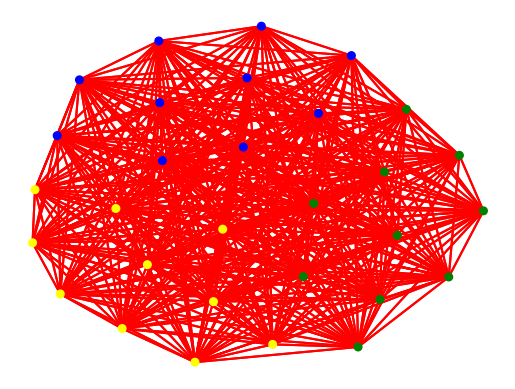

In [21]:
layout = {}
for node in graph.nodes:
    #print(node)
    layout[node] = positions_first_loop[graph.mapping.to_idx(node)].tolist()
#print(layout)    
pp.plot(mo_model.layers[1], layout=layout, backend='matplotlib' ,**style)

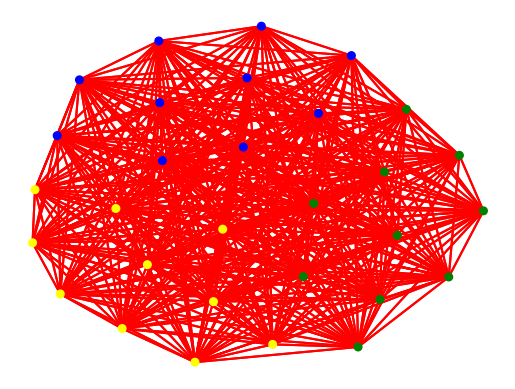

In [22]:
layout = {}
for node in graph.nodes:
    #print(node)
    layout[node] = positions_second_loop[graph.mapping.to_idx(node)].tolist()
#print(layout)    
pp.plot(mo_model.layers[1], layout=layout, backend='matplotlib' ,**style)

## Metrics

In [ ]:
def barycentre(layout, nodes=None):
    if nodes==None:
        node_positions = torch.tensor(list(layout.values())).to(torch.float64)
    else:
        node_positions = torch.tensor([layout[node] for node in nodes]).to(torch.float64)
    return torch.mean(node_positions, dim=0)

# causal_path_set über temporal_shortest_paths bekommen?
def causal_path_dispersion(temp_graph, layout, causal_path_set):
    numerator = 0
    for path in causal_path_set:
        # get positions of nodes of path
        position_nodes = torch.tensor([layout[node] for node in path])
        # Add the summand of the corresponding path to the counter
        numerator += torch.sum(torch.norm(position_nodes - barycentre(layout, path), dim=1))
    numerator *= temp_graph.N
    # calculate denominator
    positions = torch.tensor(list(layout.values()))
    denominator = torch.sum(torch.norm( positions - barycentre(layout), dim=1)) * len(causal_path_set)
    return numerator/denominator

def get_causal_path_set(temp_graph, delta):
    # get shortest temporal paths
    dist, pred = pp.algorithms.temporal_shortest_paths(temp_graph, delta)
    pred = pred
    causal_path_set = []

    # go through every pair of nodes
    for node_i in range(temp_graph.N):
        for node_j in range(temp_graph.N):
            if pred[node_i, node_j] >= 0:
                # initialize path
                causal_path = [node_j]
                current_node = node_j

                # append predecessor
                while pred[node_i, current_node] != node_i:
                    current_node = pred[node_i, current_node]
                    causal_path.insert(0, current_node)

                # insert starting node
                causal_path.insert(0, node_i)
                # add path to set of paths
                causal_path_set.append(torch.tensor(causal_path))

    return causal_path_set


def closeness_eccentricity(temp_graph, layout, delta, percentile):
    # get closeness centrality of all nodes
    closeness_centrality = pp.algorithms.centrality.temporal_closeness_centrality(temp_graph, delta)
    closeness_values = torch.tensor(list(closeness_centrality.values()), dtype=torch.float32)
    
    print(closeness_centrality)

    # determine treshold for upper percentile
    threshold = torch.quantile(closeness_values, 1 - percentile)
    
    # filter nodes based on treshold
    keys = list(closeness_centrality.keys())
    percentile_keys = [keys[i] for i in torch.where(closeness_values >= threshold)[0]]
    layout_percentile_nodes = torch.tensor([layout[key] for key in percentile_keys])
    
    # determine barycenter
    barycenter_layout = barycentre(layout)
    
    # determine numerator and denominator of formula for closeness_eccentricity
    numerator = torch.sum(torch.norm(layout_percentile_nodes - barycenter_layout, dim=1)) * temp_graph.N
    all_layout_values = torch.tensor(list(layout.values()))
    denominator = torch.sum(torch.norm(all_layout_values - barycenter_layout, dim=1)) * len(percentile_keys)
    
    return numerator / denominator

def edge_crossing(temp_graph, layout):
    # initialize counter
    counter = 0
    # get undirected (since direction doesn't matter) static graph
    static_graph = temp_graph.to_static_graph().to_undirected()
    # get edges
    edges = list(static_graph.edges)
    # every edge {'a','b'} is contained two times (as ('a','b') and as ('b','a'))
    # remove second entry, since direction isn't important for edge crossing
    edges = list(set(tuple(sorted(edge)) for edge in edges))
    # for every pair of edges
    for i in range(len(edges)):
        for j in range(i + 1, len(edges)):
            
            # check if the edges intersect (if no two nodes are the same) -> if so, increase counter
            if edges[i][0] not in edges[j] and edges[i][1] not in edges[j] and edge_intersection(layout[edges[i][0]], layout[edges[i][1]],
                            layout[edges[j][0]], layout[edges[j][1]]):
                counter += 1

    return counter

def edge_intersection(A1, A2, B1, B2):
    # formula for intersection is
    # x = det1 * (x3 - x4) - (x1 - x2) * det2 / (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    # y = det1 * (y3 - y4) - (y1 - y2) * det2 / (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    # where
    # det1 = x1 * y2 - y1 * x2
    # det2 = x3 * y4 - y3 * x4

    # get coordinates
    x1, y1 = A1
    x2, y2 = A2
    x3, y3 = B1
    x4, y4 = B2

    # determine denomitator
    denominator = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)

    # check if edges are parallel (denominator = 0)
    if torch.isclose(torch.tensor(float(denominator)), torch.tensor(0.0)):
        return False

    # determine determinants for nummerator
    det1 = x1 * y2 - y1 * x2
    det2 = x3 * y4 - y3 * x4

    # determine intersection of lines going through A1 and A2 resp. B1 and B2
    x = (det1 * (x3 - x4) - (x1 - x2) * det2) / denominator
    y = (det1 * (y3 - y4) - (y1 - y2) * det2) / denominator
    intersection = torch.tensor([x, y])

    # check if intersection is on edges 
    if is_on_segment(A1, intersection, A2) and is_on_segment(B1, intersection, B2):
        return True
    else:
        return False 

# checks if intersectiion q lies on line from p to r
def is_on_segment(p, q, r):
    return (torch.min(torch.tensor([p[0], r[0]])) <= q[0] <= torch.max(torch.tensor([p[0], r[0]]))) and \
           (torch.min(torch.tensor([p[1], r[1]])) <= q[1] <= torch.max(torch.tensor([p[1], r[1]])))


### Testen der Metriken

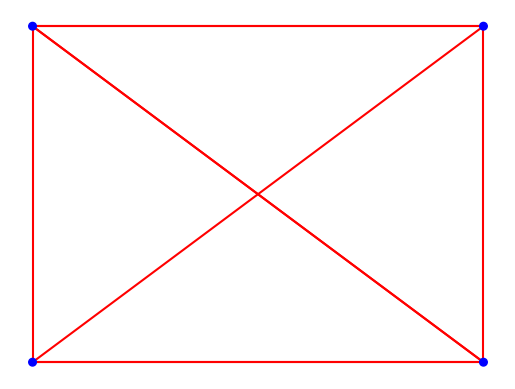

In [63]:
tedges = [('a', 'b', 1),('a', 'b', 2), ('b', 'a', 3), ('b', 'c', 3), ('d', 'c', 4), ('a', 'b', 4), ('c', 'b', 4),
              ('c', 'd', 5), ('b', 'a', 5), ('c', 'b', 6), ('a', 'c', 6), ('b', 'd', 6), ('a', 'd', 6)]
graph = pp.TemporalGraph.from_edge_list(tedges)
layout= {'a':[0,0], 'b':[1,0], 'c':[0,1], 'd':[1,1]}

pp.plot(graph.to_static_graph(), layout=layout, backend="matplotlib")

In [41]:
print(edge_crossing(graph, layout))

1


Durch einfaches nachzählen sieht man, dass der Wert passt.

In [54]:
print(barycentre(layout))

tensor([0.5000, 0.5000], dtype=torch.float64)


Der Barycenter ist hier $\frac{1}{4} \cdot [0,0] + [1,0] + [0,1] + [1,1] = [0.5, 0.5] $. Damit ist der Wert also richtig.

In [70]:
print(closeness_eccentricity(graph, layout, 1, 0.1))

100%|██████████| 6/6 [00:00<00:00, 269.53it/s]

{'a': 4.5, 'b': 6.0, 'c': 9.0, 'd': 9.0}
tensor(1., dtype=torch.float64)


Wir gehen davon aus, dass die Funktion pp.algorithms.centrality.temporal_closeness_centrality funktioniert. Dann erhalten wir in diesem Fall eine closeness centrality von {'a': 4.5, 'b': 6.0, 'c': 9.0, 'd': 9.0}. In den oberen 10 % liegen damit c und d.
Der Barycenter alle Knoten beträgt $[0.5, 0.5]$.  Damit ergibt sich für den Zähler 

$||[1, 0] - [0.5, 0.5]|| + ||[1, 1] - [0.5, 0.5]|| \cdot 4 = 8 \cdot \sqrt{0.5}$.

 Da alle Knoten $\sqrt{0.5}$ vom Bayrcenter entfernt sind, ergibt sich für den Nenner 
 
 $2 \cdot 4 \cdot \sqrt{0.5} = 8 \cdot \sqrt{0.5}$. 
 
 Somit ist das Ergebnis eins. Damit ist der vom der Funktion ausgegeben Wert richtig.

In [68]:
causal_path = [['a', 'b'], ['b','a'], ['a','b','c']]
print(causal_path_dispersion(graph, layout, causal_path))

tensor(1.8678, dtype=torch.float64)


Wie leicht nachzurechnen ist, sind die Barycentre der Pfade $[0, 0.5], [0, 0.5], [0.33, 0.33]$.

Die Summe über die Knoten des ersten Pfades ist dann 

$||([0,0] - [0, 0.5])|| + ||([0,1] - [0, 0.5])|| = 1$

Für den zweiten Pfad erhält man das selbe Ergebnis. Für den dritten Pfad ergibt sich:

$||[0,0] - [0.33, 0.33]|| + ||[0,1] - [0.33, 0.33]|| + ||[1,0] - [0.33, 0.33]||= 1.96$

Der Wert des Zählers ist damit:

$4 \cdot (1 + 1 + 1.96) = 15.84$

Der Nenner berechnet sich ähnlich zu oben. Der Wert ist

$ 3 \cdot 4 \cdot \sqrt{0.5} = 8.49 $

Das Ergebnis ist damit $ \frac{15.84}{8.49} = 1.87$. Damit ist auch der von der Funktion berechnete Wert richtig.

